In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import glob
from copy import deepcopy

# from pymatgen.core import Structure
# from pymatgen.io.vasp.outputs import Vasprun
# from pymatgen.analysis.diffusion.analyzer import DiffusionAnalyzer
# from pymatgen.analysis.diffusion.aimd.van_hove import VanHoveAnalysis, EvolutionAnalyzer

from sklearn.linear_model import LinearRegression 

# PCF

In [4]:
file = open('MD-VASP/v2/LLZO_Ia3d_Al20_run0/PCDAT', 'r')
lines = file.readlines()
pcskal = float(lines[8])
pcfein = float(lines[9])
PCF = lines[12:]
PCF = np.array(PCF, dtype='float')
r = np.arange(PCF.size)*(pcskal/pcfein)*1e10
file.close()

[]


ValueError: min() arg is an empty sequence

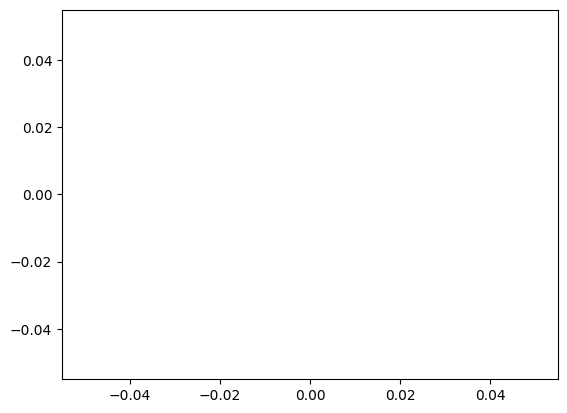

In [3]:
plt.plot(r, PCF)
plt.plot([min(r), max(r)], [1, 1], color='black')
plt.xlabel('Radial Distance (angstroms)')
plt.xlim([min(r), max(r)])
plt.ylim([min(PCF), max(PCF)+.1])
plt.ylabel('PCF')
plt.title('Pair Correlation Function')
plt.axvline(1.38, color='black')
plt.show()

# Relaxation Convergence

Text(0, 0.5, 'Potential Energy (eV)')

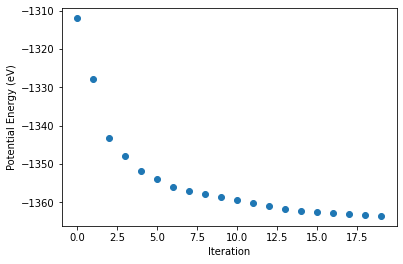

In [4]:
with open('Relaxation/LLZO_Ia3d_Al30_initial/LLZO_Ia3d_Al30_partial_relaxed/LLZO_Ia3d_Al30_partial_00.vasp_output', 'r') as f:
    lines = f.readlines()
E_conv = np.array([])
for line in lines:
    if 'E0=' in line:
        values = re.findall(r"[-+]?\d*\.\d+|\d+", line)
        E_conv = np.append(E_conv, float(values[4])*(10**float(values[5])))

plt.scatter(range(len(E_conv)), E_conv)
plt.xlabel('Iteration')
plt.ylabel('Potential Energy (eV)')

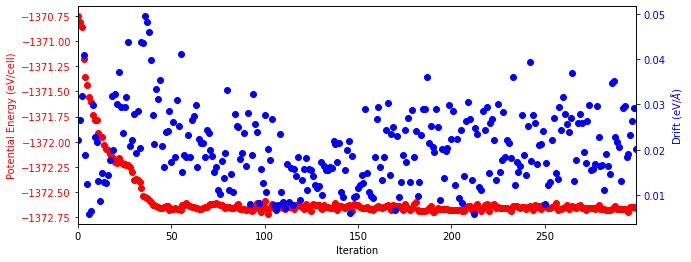

In [2]:
file = open('Relaxation/LLZO_Ia3d_Al00/output_file')
lines = file.readlines()
E = np.array([])
for line in lines:
    if 'E0=' in line:
        values = re.findall(r"[-+]?\d*\.\d+|\d+", line)
        E = np.append(E, float(values[4]) * 10**float(values[5]))
file.close()

file = open('Relaxation/LLZO_Ia3d_Al00/OUTCAR')
lines = file.readlines()
drift = np.array([])
for line in lines:
    if 'total drift' in line:
        values = re.findall(r"[-+]?\d*\.\d+|\d+", line)
        drift = np.append(drift, np.sqrt(float(values[0])**2 + float(values[1])**2 + float(values[1])**2))
file.close()

fig, ax1 = plt.subplots(figsize=(10,4))
ax1.scatter(range(len(E)), E, color='red')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Potential Energy (eV/cell)', color='red')
ax1.tick_params(axis='y', labelcolor='red')

ax2 = ax1.twinx()
ax2.scatter(range(len(drift)), drift, color='blue')
ax2.set_ylabel(r'Drift (eV/$\AA$)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

ax1.autoscale(enable=True, axis='x', tight=True)

plt.show()

# Structure Selection

23
97


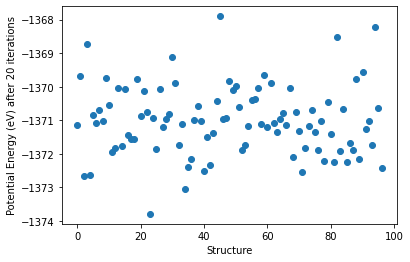

In [2]:
E = np.array([])
for file in sorted(glob.glob('Relaxation/LLZO_Ia3d_Al00_initial/LLZO_Ia3d_Al00_partial_relaxed/LLZO_Ia3d_Al00_partial_*.vasp_output')):
    with open(file, 'r') as f:
        lines = f.readlines()
    E_conv = np.array([])
    for line in lines:
        if 'E0=' in line:
            values = re.findall(r"[-+]?\d*\.\d+|\d+", line)
            E_conv = np.append(E_conv, float(values[4])*(10**float(values[5])))
    if len(E_conv) > 0:
        E = np.append(E, E_conv[-1])
    else:
        continue
plt.scatter(range(len(E)), E)
plt.xlabel('Structure')
plt.ylabel('Potential Energy (eV) after 20 iterations')
print(np.argmin(E))
print(len(E))

# Learning Curves

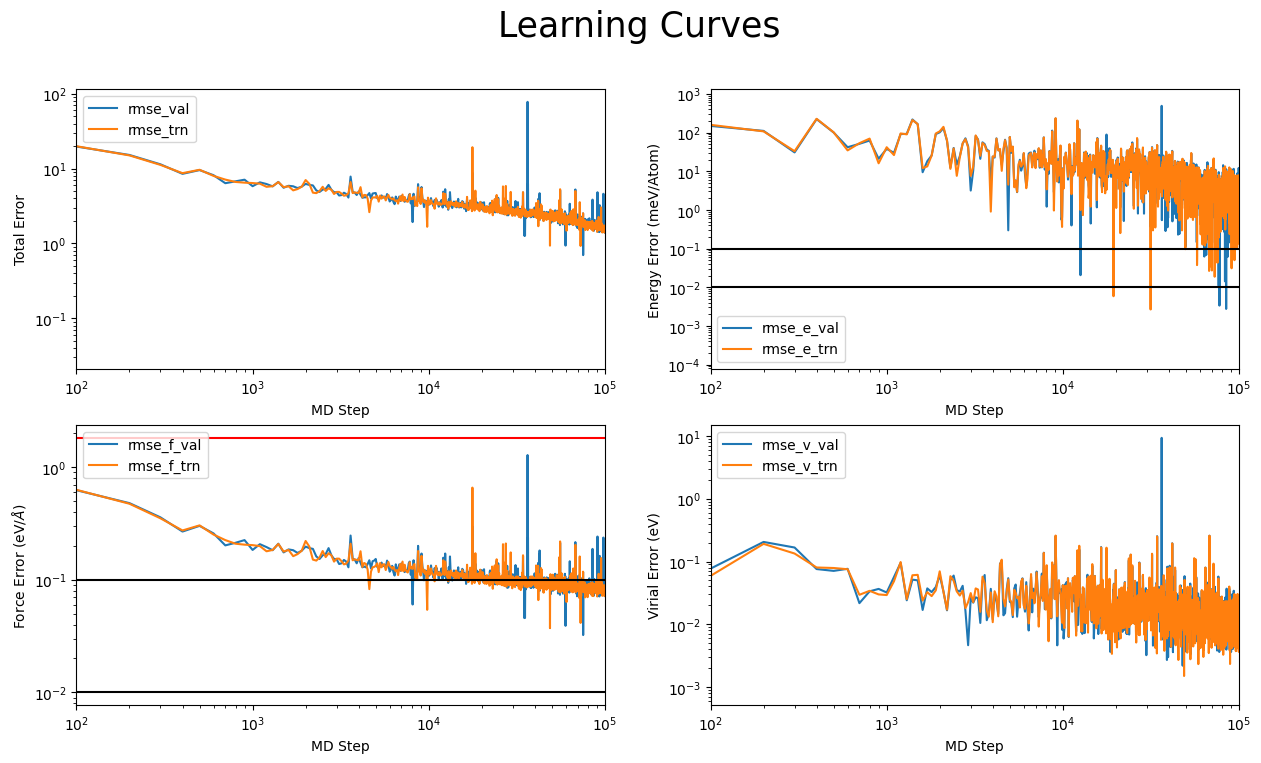

In [8]:
data = np.genfromtxt('Azure/model/lcurve.out', names=True)
fig, axs = plt.subplots(2,2, figsize=(15,8))

axs[0,0].plot(data['step'], data['rmse_val'], label='rmse_val')
axs[0,0].plot(data['step'], data['rmse_trn'], label='rmse_trn')
axs[0,0].legend()
axs[0,0].set_xscale('log')
axs[0,0].set_yscale('log')
axs[0,0].set_xlim([10**2, 10**5])
axs[0,0].set_xlabel("MD Step")
axs[0,0].set_ylabel("Total Error")

axs[0,1].plot(data['step'], data['rmse_e_val']*1000, label='rmse_e_val')
axs[0,1].plot(data['step'], data['rmse_e_trn']*1000, label='rmse_e_trn')
axs[0,1].plot([0, max(data['step'])], [10**-1, 10**-1], color='black')
axs[0,1].plot([0, max(data['step'])], [10**-2, 10**-2], color='black')
axs[0,1].legend()
axs[0,1].set_xscale('log')
axs[0,1].set_yscale('log')
axs[0,1].set_xlim([10**2, 10**5])
axs[0,1].set_xlabel("MD Step")
axs[0,1].set_ylabel("Energy Error (meV/Atom)")

axs[1,0].plot(data['step'], data['rmse_f_val'], label='rmse_f_val')
axs[1,0].plot(data['step'], data['rmse_f_trn'], label='rmse_f_trn')
axs[1,0].plot([0, max(data['step'])], [10**-1, 10**-1], color='black')
axs[1,0].plot([0, max(data['step'])], [10**-2, 10**-2], color='black')
axs[1,0].plot([0, max(data['step'])], [1.82, 1.82], color='red')
axs[1,0].legend()
axs[1,0].set_xscale('log')
axs[1,0].set_yscale('log')
axs[1,0].set_xlim([10**2, 10**5])
axs[1,0].set_xlabel("MD Step")
axs[1,0].set_ylabel(r"Force Error (eV/$\AA$)")

axs[1,1].plot(data['step'], data['rmse_v_val'], label='rmse_v_val')
axs[1,1].plot(data['step'], data['rmse_v_trn'], label='rmse_v_trn')
axs[1,1].legend()
axs[1,1].set_xscale('log')
axs[1,1].set_yscale('log')
axs[1,1].set_xlim([10**2, 10**5])
axs[1,1].set_xlabel("MD Step")
axs[1,1].set_ylabel("Virial Error (eV)")

plt.suptitle("Learning Curves", fontsize=25)
plt.show()

In [7]:
force_av = np.array([])
for name in glob.glob('MD-VASP/LLZO_Ia3d_Al*/OUTCAR'):
    f = open(name, 'r')
    force = np.array([])
    while f:
        line = f.readline()
        if line== "":
            break
        if 'TOTAL-FORCE' in line:
            f.readline()
            data = np.array([])
            for i in range(188):
                line = f.readline()
                values = re.findall(r"[-+]?\d*\.\d+|\d+", line)
                values = [float(x) for x in values]
                data = np.append(data, np.linalg.norm(values[3:]))
            force = np.append(force, data.mean())
    f.close()
    force_av = np.append(force_av, force.mean())
print(force_av)

[1.81860989 1.83077971 1.81615915]


# LAMMPS Data Processing

In [25]:
import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression

In [30]:
def D_func(slope):
    # Slope in A2 /ps
    # Output in     cm2/s
    return (slope / 6) * 10**12 / (10**(8*2))

def N_eff_func(ave_msd, a):
    return max(ave_msd) * 420 / (a**2)

def sigma_func(D, N_mobile_ions, unit_cell_volume, T):
    return ( (D * (10**-2)**2) * (N_mobile_ions/(unit_cell_volume*(10**-10)**3)) * ((1.6e-19)**2) / (1.38e-23*T) ) * (10**3/10**2)

def E_a_func(slope):
    return -slope*(8.62*10**-5)*np.log(10)

In [56]:
a = 2.4 # Approx. site hopping length, for use in N_Eff
record_freq = 10
columns = ['Doping Element', 'Doping Concentration (Formulaic)', 'Configuration', 'Temperature (K)', 
           'Mean Diffusivity (cm^2/s)', 'STD Diffusivity (cm^2/s)',
           'Mean Conductivity (mS/cm)', 'STD Conductivity (mS/cm)',
           'Mean Correlation Factor', 'STD Correlation Factor', 'N Eff (>500)']
diffusivity = pd.DataFrame(columns=columns)
for element in ['Al']:
    for concentration in np.arange(0, 0.75, 0.05):
        for (T, unit_cell_volume, dt) in [(300, 25.98808**3, 0.004), (600, 26.08711**3, 0.004), (900, 26.18614**3, 0.001), (1200, 26.28517**3, 0.001), (1500, 26.38420**3, 0.001)]:
            for config in [0, 1, 2]:

                linearModel = LinearRegression()

                # MSD
                D_arr = []
                ave_msd = []
                for i,file in enumerate(glob.glob('MD-LAMMPS/data/LLZO_Ia3d_%s%02.f_%.0f/msd*-%.0f.out' % (element, 100*concentration, config, T))):
                    df = pd.read_csv(file, sep=" ", low_memory=False)
                    pos = np.array(df['Time-averaged'])
                    msd = pos[6::5].astype('float64')

                    ave_msd.append(msd)

                    time = dt*record_freq*np.array(range(msd.shape[0]))
                    linearModel.fit(time[int(10/(dt*record_freq)):].reshape(-1,1), msd[int(10/(dt*record_freq)):])
                    D = D_func(linearModel.coef_[0])
                    D_arr.append(D)

                if not np.any(ave_msd):
                    continue
                ave_msd = np.array(ave_msd).mean(axis=0)
                N_eff = N_eff_func(ave_msd, a)

                D_ave = np.mean(D_arr)
                D_std = np.std(D_arr)
                
                # MSCD
                Dj_arr = []
                ave_mscd = []
                for i,file in enumerate(glob.glob('MD-LAMMPS/data/LLZO_Ia3d_%s%02.f_%.0f/mscd*-%.0f.out' % (element, 100*concentration, config, T))):
                    df = pd.read_csv(file, sep=" ", low_memory=False)
                    pos = np.array(df['Time-averaged'])
                    mscd = pos[6::5].astype('float64')

                    ave_mscd.append(mscd)

                    time = dt*record_freq*np.array(range(mscd.shape[0]))
                    linearModel.fit(time[int(10/(dt*record_freq)):].reshape(-1,1), mscd[int(10/(dt*record_freq)):])
                    Dj = D_func(linearModel.coef_[0])
                    Dj_arr.append(Dj)

                if not np.any(ave_mscd):
                    continue
                ave_mscd = np.array(ave_mscd).mean(axis=0)

                Dj_ave = np.mean(Dj_arr)
                Dj_std = np.std(Dj_arr)
                
                # Sigma
                N_mobile_ions = 448 - 1200*concentration/5
                sigma_arr = sigma_func(np.array(D_arr), N_mobile_ions, unit_cell_volume, T)
                sigma_ave = np.mean(sigma_arr)
                sigma_std = np.std(sigma_arr)
                
                # Correlation factor
                corr_arr = np.array(D_arr)/np.array(Dj_arr)
                corr_ave = np.mean(corr_arr)
                corr_std = np.std(corr_arr)       

                # Put into total dataframe
                entry = pd.DataFrame([[element, concentration, config, T, D_ave, D_std, sigma_ave, sigma_std, corr_ave, corr_std, N_eff]], columns=columns)
                diffusivity = pd.concat([diffusivity, entry], ignore_index=True)

,Doping Element,Doping Concentration (Formulaic),Configuration,Activation Energy (eV),RT D (cm2/s),Average Correlation
0,Al,0.00,0,0.262230,5.353390e-07,2.996340
1,Al,0.05,0,0.238246,1.143915e-06,3.341948
2,Al,0.05,1,0.276386,3.101827e-07,3.045607
3,Al,0.10,0,0.245629,8.533358e-07,1.855506
4,Al,0.10,1,0.264522,4.461476e-07,3.072458
5,Al,0.15,0,0.259993,4.918315e-07,-1.401018
6,Al,0.15,1,0.288454,1.842986e-07,3.071251
7,Al,0.20,0,0.286089,1.952302e-07,3.085406
8,Al,0.20,1,0.291544,1.579380e-07,2.966115
9,Al,0.25,0,0.274338,2.685890e-07,3.151253


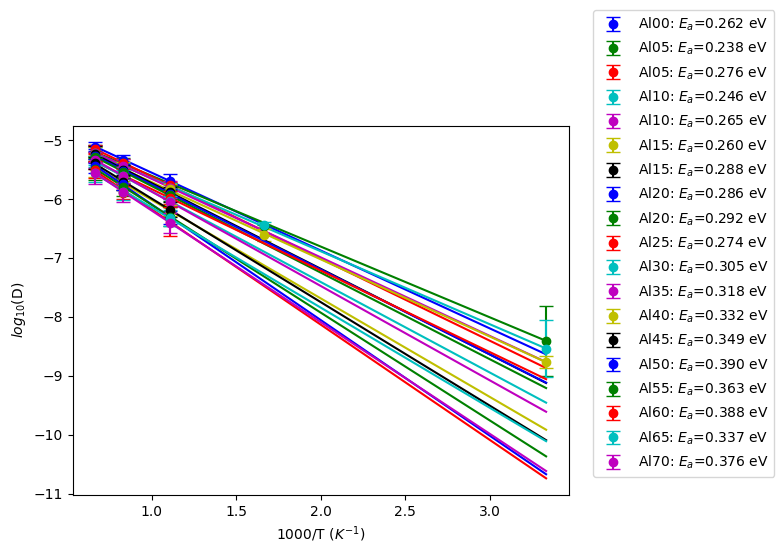

In [66]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Simulation
summary_columns = ['Doping Element', 'Doping Concentration (Formulaic)', 'Configuration', 
           'Activation Energy (eV)', 'RT D (cm2/s)', 'Average Correlation']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
arrhenius = pd.DataFrame(columns=summary_columns)
diffusivity_copy = diffusivity.reset_index()
groups = diffusivity_copy.groupby(['Doping Element', 'Doping Concentration (Formulaic)', 'Configuration']).groups
for i,key in enumerate(groups):
    group = groups[key]
    group_diffusivity = diffusivity_copy.iloc[group].reset_index()

    x = 1./group_diffusivity[['Temperature (K)']]
    y = np.log10(group_diffusivity['Mean Diffusivity (cm^2/s)'].astype('float32'))
    weights = group_diffusivity['STD Diffusivity (cm^2/s)'] / group_diffusivity['Mean Diffusivity (cm^2/s)']

    model = LinearRegression()
    model.fit(x, y, weights)
    E_a = E_a_func(model.coef_[0])

    corr = group_diffusivity['Mean Correlation Factor']
    
    D_0 = np.exp(model.intercept_)
    D_RT = D_0 * np.exp(-E_a / (8.62*10**-5 * 298))
    x_prime = np.linspace(np.min(x['Temperature (K)']), 1/300, 100).reshape(-1,1)

    entry = pd.DataFrame([[key[0], key[1], key[2], E_a, D_RT, np.mean(corr)]], columns=summary_columns)
    arrhenius = pd.concat([arrhenius, entry], ignore_index=True)
        
    plt.errorbar(1000*x, y, yerr=weights, fmt='o', capsize=5, 
                label=r'%s%02.f: $E_a$=%.3f eV' % (key[0], 100*key[1], E_a), c=colors[i%(len(colors)-1)])
    plt.plot(1000*x_prime, model.predict(x_prime), c=colors[i%(len(colors)-1)])

display(arrhenius)

# # Experimental Data
# exp_diffusivity = pd.DataFrame([['Al', 0, None, 291, None, 0.337, None, None, None, None, None],
#                                 ['Al', 0, None, 298, None, 0.467, None, None, None, None, None], 
#                                 ['Al', 0, None, 323, None, 1.190, None, None, None, None, None], 
#                                ], columns=columns) 
# x = 1000./exp_diffusivity['Temperature (K)']
# y = np.log10(exp_diffusivity['Conductivity (mS/cm)'] * exp_diffusivity['Temperature (K)'])
# plt.scatter(x, y,
#             label=r'%s: $E_a$=%.3f eV, DOI: 10.1002/anie.200701144' % ('Exp Al00', 0.30),
#             marker = 'x'
#            )

# exp_diffusivity = pd.DataFrame([['Al', 0.2, None, 1000/2.68, None, 3.533, None, None, None, None, None],
#                                 ['Al', 0.2, None, 1000/2.88, None, 1.735, None, None, None, None, None],
#                                 ['Al', 0.2, None, 1000/3.10, None, 0.751, None, None, None, None, None],
#                                 ['Al', 0.2, None, 1000/3.36, None, 0.293, None, None, None, None, None],
#                                 ['Al', 0.2, None, 1000/3.67, None, 0.084, None, None, None, None, None],
#                                 ['Al', 0.2, None, 1000/3.80, None, 0.045, None, None, None, None, None],
#                                 ['Al', 0.2, None, 1000/3.95, None, 0.024, None, None, None, None, None],
#                                ], columns=columns) 
# x = 1000./exp_diffusivity['Temperature (K)']
# y = np.log10(exp_diffusivity['Conductivity (mS/cm)'] * exp_diffusivity['Temperature (K)'])
# plt.scatter(x, y,
#             label=r'%s: $E_a$=%.3f eV,  DOI: 10.1038/srep18053' % ('Exp Al20', 0.36),
#             marker = 'x'
#            )

plt.legend(loc=(1.05, 0.05))
plt.xlabel(r'1000/T ($K^{-1}$)')
plt.ylabel(r'$log_{10}$(D)')
plt.show()

,Doping Element,Doping Concentration (Formulaic),Mean Activation Energy (eV),STD Activation Energy (eV),Mean RT D (cm2/s),STD RT D (cm2/s),Average Correlation
0,Al,0.00,0.262230,0.000000,5.353390e-07,0.000000e+00,3.45083
1,Al,0.05,0.257316,0.019070,7.270489e-07,4.168662e-07,3.45083
2,Al,0.10,0.255075,0.009446,6.497417e-07,2.035941e-07,3.45083
3,Al,0.15,0.274223,0.014230,3.380651e-07,1.537665e-07,3.45083
4,Al,0.20,0.288817,0.002728,1.765841e-07,1.864610e-08,3.45083
5,Al,0.25,0.274338,0.000000,2.685890e-07,0.000000e+00,3.45083
6,Al,0.30,0.304815,0.000000,9.186070e-08,0.000000e+00,3.45083
7,Al,0.35,0.317791,0.000000,5.907331e-08,0.000000e+00,3.45083
8,Al,0.40,0.331813,0.000000,3.193030e-08,0.000000e+00,3.45083
9,Al,0.45,0.348697,0.000000,1.841372e-08,0.000000e+00,3.45083


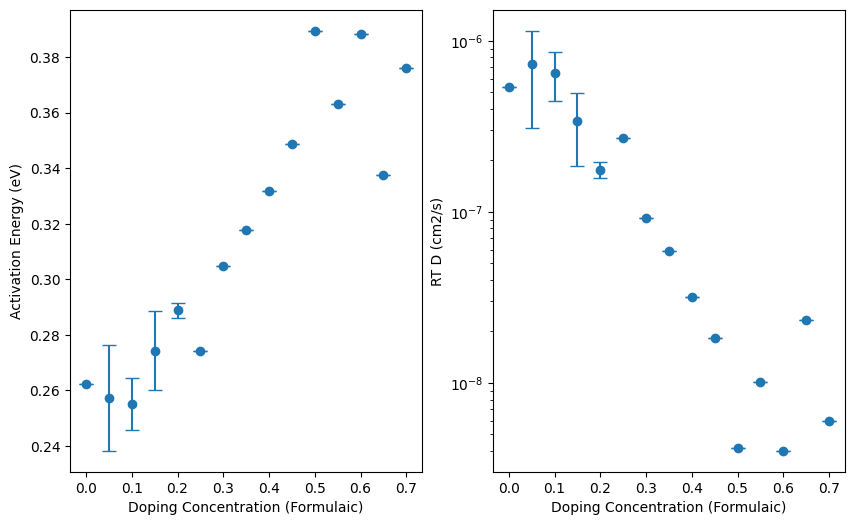

In [73]:
fig, axs = plt.subplots(1,2, figsize=(10,6))

groups = arrhenius.groupby(['Doping Element', 'Doping Concentration (Formulaic)']).groups
reduced_summary_columns = ['Doping Element', 'Doping Concentration (Formulaic)', 
           'Mean Activation Energy (eV)', 'STD Activation Energy (eV)',
           'Mean RT D (cm2/s)', 'STD RT D (cm2/s)', 'Average Correlation']
reduced_arrhenius = pd.DataFrame(columns=reduced_summary_columns)
for key in groups:
    group = groups[key]
    group_arrhenius = arrhenius.iloc[group].reset_index()

    D_ave = np.mean(group_arrhenius['RT D (cm2/s)'])
    D_std = np.std(group_arrhenius['RT D (cm2/s)'])
    Ea_ave = np.mean(group_arrhenius['Activation Energy (eV)'])
    Ea_std = np.std(group_arrhenius['Activation Energy (eV)'])

    entry = pd.DataFrame([[key[0], key[1], Ea_ave, Ea_std, D_ave, D_std, np.mean(corr)]], columns=reduced_summary_columns)
    reduced_arrhenius = pd.concat([reduced_arrhenius, entry], ignore_index=True)

display(reduced_arrhenius)

axs[0].errorbar(reduced_arrhenius['Doping Concentration (Formulaic)'], 
                reduced_arrhenius['Mean Activation Energy (eV)'], 
                yerr=reduced_arrhenius['STD Activation Energy (eV)'], fmt='o', capsize=5)

axs[1].errorbar(reduced_arrhenius['Doping Concentration (Formulaic)'], 
                reduced_arrhenius['Mean RT D (cm2/s)'], 
                yerr=reduced_arrhenius['STD RT D (cm2/s)'], fmt='o', capsize=5)

axs[0].set_xlabel('Doping Concentration (Formulaic)')
axs[0].set_ylabel('Activation Energy (eV)')
axs[1].set_xlabel('Doping Concentration (Formulaic)')
axs[1].set_ylabel('RT D (cm2/s)')
axs[1].set_yscale('log')

plt.show()

##### Pure LLZO Correlation Factor at 900K: 3.0

# Testing VASP File Writing

In [17]:
import numpy as np

from pymatgen.core import Structure
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.transformations.standard_transformations import DiscretizeOccupanciesTransformation
from pymatgen.transformations.standard_transformations import AutoOxiStateDecorationTransformation
from pymatgen.transformations.standard_transformations import RemoveSpeciesTransformation
from pymatgen.transformations.advanced_transformations import SQSTransformation

### Manually edit original .cif file

In [20]:
structure = Structure.from_file(filename='structure_files/LLZO_Ia3d_experimental.cif')
analyzer = SpacegroupAnalyzer(structure)
structure = analyzer.find_primitive()

print(structure.composition)
for i,site in enumerate(structure.sites):
    if site.species['Li'] == 0.69:
        structure.sites[i].species = {'Li':1}
    elif site.species['La'] == 0.985:
        structure.sites[i].species = {'La':1}
    elif site.species['Li'] == 0.32:
        structure.sites[i].species = {'Li':0.333}
print(structure.composition)

DOT = DiscretizeOccupanciesTransformation()
structure_dot = DOT.apply_transformation(structure)
AOSDT = AutoOxiStateDecorationTransformation()
structure_aosdt = AOSDT.apply_transformation(structure_dot)
structure_aosdt.to(filename='structure_files/LLZO_Ia3d_experimental_cleaned.cif')

Li23.64 Al0.864 La11.82 Zr8 O48
Li27.984 La12 Zr8 O48


### Get ordered structure from disordered structure

In [21]:
disordered_structure = Structure.from_file('structure_files/LLZO_Ia3d_experimental_cleaned.cif')
for i,site in enumerate(disordered_structure):
    species = site.species.as_dict()
    total = 0
    for elem in species:
        total += species[elem]
    species['H'] = 1-total
    disordered_structure.sites[i].species = species
SQST = SQSTransformation(scaling=1, cluster_size_and_shell={2: 1},
                         search_time=60, directory='.sqs')
ordered_structure = SQST.apply_transformation(disordered_structure)
RST = RemoveSpeciesTransformation('H')
ordered_structure = RST.apply_transformation(ordered_structure)
%cd ..
ordered_structure.to(filename='structure_files/LLZO_Ia3d_ordered.cif')

RuntimeError: run_mcsqs requires first installing AT-AT, see https://www.brown.edu/Departments/Engineering/Labs/avdw/atat/